# 1D harmonic oscillator physics-informed neural network (PINN)

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~
$$


## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


# Jax Implementation

## MLP PINN

100%|██████████| 1000000/1000000 [05:24<00:00, 3077.91it/s, Loss=6.5483596e-06]


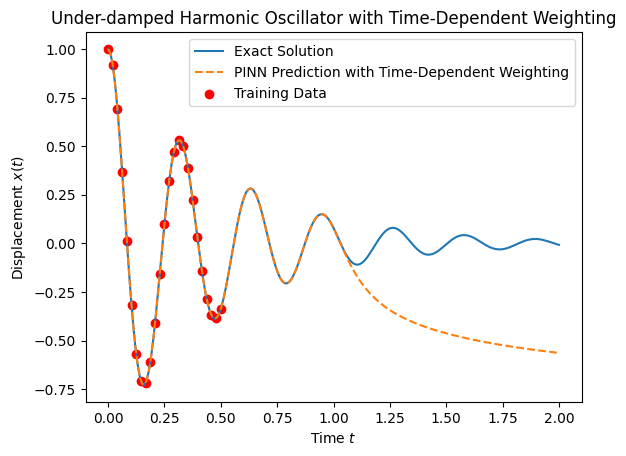

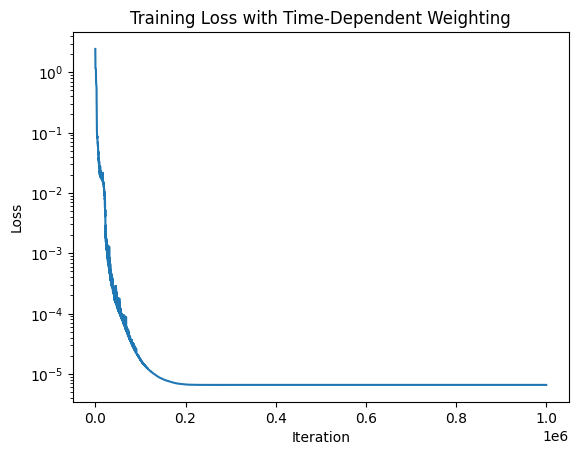

In [3]:
import numpy as onp  # Original NumPy
import jax.numpy as np
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = np.sqrt(w0 ** 2 - d ** 2)
    phi = np.arctan(-d / w)
    A = 1.0 / (2.0 * np.cos(phi))
    cos_term = np.cos(phi + w * t)
    exp_term = np.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the MLP function
def MLP(layers, activation=np.tanh):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, _ = random.split(key)
            glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        H = inputs
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs

    return init, apply

# Define the PINN model class with time-dependent weighting
class PINN:
    def __init__(self, key, layers, mu, k):

        # Initialize the neural network
        self.init, self.apply = MLP(layers, activation=np.tanh)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.90)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

        # Decay rate for time-dependent weighting
        self.lambda_decay = 1.0  # You can adjust this value

    def neural_net(self, params):
        def net_apply(t):
            outputs = self.apply(params, t.reshape(-1, 1))
            return outputs.squeeze()  # Ensure output is a scalar
        return net_apply

    def residual_net(self, params):
        net_apply = self.neural_net(params)
        def res_apply(t):
            x = net_apply(t)
            x_t = grad(net_apply)(t)
            x_tt = grad(grad(net_apply))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_apply

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss with time-dependent weighting
        res_apply = self.residual_net(params)
        residual_fn = vmap(res_apply)
        res = residual_fn(t_r)
        res_squared = res ** 2

        # Time-dependent weights
        # Compute weights: w(t) = exp(-lambda * t)
        weights_time = np.exp(-self.lambda_decay * t_r)
        weights_time /= np.sum(weights_time)  # Normalize weights

        # Optionally combine with RBA weights
        # RBA weights
        weights_rba = res_squared / np.sum(res_squared)
        # Combined weights
        weights = weights_time * weights_rba
        # Normalize combined weights
        weights /= np.sum(weights)

        # If you want to use only time-dependent weights:
        # weights = weights_time

        # Apply weights to residual loss
        loss_res = np.sum(weights * res_squared)

        # Data loss (at observed data points)
        net_apply = self.neural_net(params)
        x_pred = vmap(net_apply)(t_data)
        loss_data = np.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_apply(np.array(0.0))
        x0_t_pred = grad(net_apply)(np.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = np.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = np.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 50, 50, 50, 1]
model = PINN(key, layers, mu, k)

# Convert data to appropriate types
t_r = np.array(t_r)
t_data = np.array(t_data)
x_data = np.array(x_data)

# Adjust the decay rate as needed
model.lambda_decay = 1.0  # You can experiment with different values

# Train the model
model.train(nIter=1000000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = np.linspace(0.0, 2.0, 200)
t_test = np.array(t_test)
net_apply = model.neural_net(params)
x_pred = vmap(net_apply)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='PINN Prediction with Time-Dependent Weighting')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with Time-Dependent Weighting')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(onp.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with Time-Dependent Weighting')
plt.show()


## KAN PINN

In [22]:
import numpy as onp  # Original NumPy
import jax.numpy as np
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Import Flax modules
from flax import linen as nn

# Import the KAN model
from jaxkan.models.KAN import KAN

# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = np.sqrt(w0 ** 2 - d ** 2)
    phi = np.arctan(-d / w)
    A = 1.0 / (2.0 * np.cos(phi))
    cos_term = np.cos(phi + w * t)
    exp_term = np.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the PINN model class using KAN
class PINN:
    def __init__(self, key, layers, mu, k):

        # Initialize the KAN model
        self.model = KAN(layer_dims=layers, add_bias=True)

        # Initialize parameters and state
        rng, init_rng = random.split(key)
        # Use a dummy input to initialize the model
        x_init = np.array([[0.0]])  # Shape (1, 1)
        variables = self.model.init(init_rng, x_init)
        self.params = variables['params']
        self.state = variables.get('state', {})

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=1000, decay_rate=0.99)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(self.params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

    def net_apply(self, params, x):
        outputs, _ = self.model.apply({'params': params, 'state': self.state}, x)
        return outputs.squeeze()  # Ensure output is a scalar

    def neural_net(self, params):
        # Define a function that can be differentiated
        def net_fn(t):
            x = t.reshape(-1, 1)
            return self.net_apply(params, x)
        return net_fn

    def residual_net(self, params):
        net_fn = self.neural_net(params)
        def res_fn(t):
            x = net_fn(t)
            x_t = grad(net_fn)(t)
            x_tt = grad(grad(net_fn))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_fn

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss
        res_fn = self.residual_net(params)
        res = vmap(res_fn)(t_r)
        res_squared = res ** 2

        # Compute attention weights based on residuals (optional)
        weights = res_squared / np.sum(res_squared)
        loss_res = np.sum(weights * res_squared)

        # Or use unweighted residual loss
        # loss_res = np.mean(res_squared)

        # Data loss (at observed data points)
        net_fn = self.neural_net(params)
        x_pred = vmap(net_fn)(t_data)
        loss_data = np.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_fn(np.array(0.0))
        x0_t_pred = grad(net_fn)(np.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = np.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = np.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 25, 25, 1]  # Adjust the layers as needed
model = PINN(key, layers, mu, k)

# Convert data to appropriate types
t_r = np.array(t_r)
t_data = np.array(t_data)
x_data = np.array(x_data)

# Train the model
model.train(nIter=100000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = np.linspace(0.0, 2.0, 200)
t_test = np.array(t_test)
net_fn = model.neural_net(params)
x_pred = vmap(net_fn)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='KAN PINN Prediction')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with KAN PINN')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(onp.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with KAN PINN')
plt.show()


 14%|█▎        | 13600/100000 [00:32<03:28, 415.13it/s, Loss=0.00016841458]


KeyboardInterrupt: 